In [1]:
#!pip install pydot

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import plotly.graph_objects as go
from keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score
from keras.utils import plot_model
from IPython.display import Image
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df = pd.read_csv('data/df_sem_duplicatas.csv')
#df = pd.read_csv('data/dfManipulated.csv')

In [4]:
df

,descricao,categoria
0,caneta bic cristal,Papelaria
1,caneta bps pilot,Papelaria
2,caneta marcador permanente acrilex ponta dupla,Papelaria
3,caneta retocar madeira branco corcel,Papelaria
4,caneta retroprojetor manter fazer castelo pont...,Papelaria
...,...,...
5019,luva galo luva galvanizada,Hidráulico
5020,luva galo luva galvanizado,Hidráulico
5021,luva educado galo luva educado galvanizada,Hidráulico
5022,luva educado galo luva educado galvanizada pol...,Hidráulico


In [5]:
label_encoder = LabelEncoder()
df['categoria'] = label_encoder.fit_transform(df['categoria'])


X = df['descricao'].values
y = df['categoria'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length =  max(len(text) for text in df['descricao'])  

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

num_classes = len(label_encoder.classes_)

vectorizer = TfidfVectorizer(max_features=len(tokenizer.word_index) + 1) 
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

initial_output_dim =1
initial_cov1d_filters =2
initial_dense_units = 1
increment = True
i = 1
epochs =50
monitor_metric = 'val_loss'

early_stopping = EarlyStopping(monitor=monitor_metric, mode='min', patience=5, restore_best_weights=True)



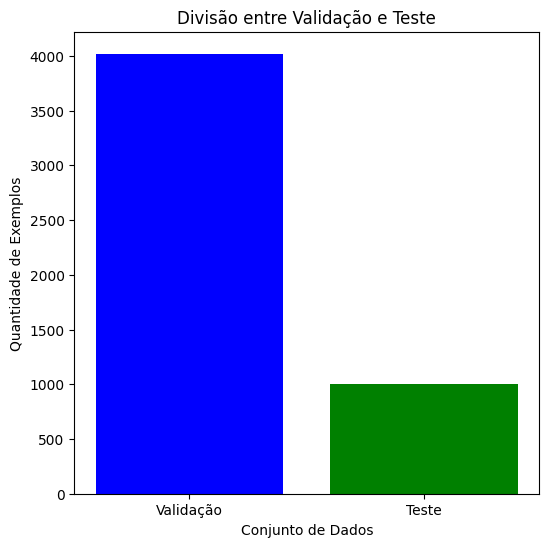

In [6]:
num_train = len(X_train)
num_test = len(X_test)

# Crie um gráfico de barras para mostrar a divisão
plt.figure(figsize=(6, 6))
plt.bar(['Validação', 'Teste'], [num_train, num_test], color=['blue', 'green'])
plt.xlabel('Conjunto de Dados')
plt.ylabel('Quantidade de Exemplos')
plt.title('Divisão entre Validação e Teste')
plt.show()

Modelo inicial

In [7]:
densidade = 1  
while True:
    model = tf.keras.Sequential([
        Dense(densidade, activation='relu', input_shape=(X_train_tfidf.shape[1],)),  
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train_tfidf, y_train, epochs=epochs, validation_data=(X_test_tfidf, y_test), verbose=0, callbacks=[early_stopping])
    if early_stopping.stopped_epoch > 0:
        break
    densidade += 1

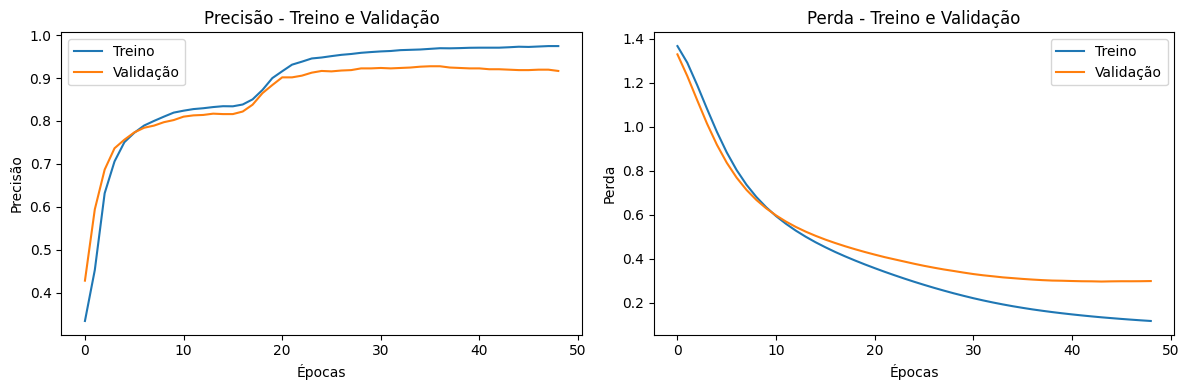

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.title('Precisão - Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda - Treino e Validação')

plt.tight_layout()
plt.show()

In [9]:
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)
print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))

32/32 [==============================] - 0s 401us/step
Classification Report:
              precision    recall  f1-score   support

   Embalagem       0.90      0.91      0.90       284
         Epi       0.96      0.96      0.96       249
  Hidráulico       0.93      0.89      0.91       140
   Papelaria       0.90      0.91      0.91       332

    accuracy                           0.92      1005
   macro avg       0.92      0.92      0.92      1005
weighted avg       0.92      0.92      0.92      1005



In [10]:
print(f"Densidade: {densidade:.4f}")
print(f"Numero de classes: {num_classes:.4f}")
model.summary()

Densidade: 2.0000
Numero de classes: 4.0000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 6606      
                                                                 
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
Total params: 6618 (25.85 KB)
Trainable params: 6618 (25.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


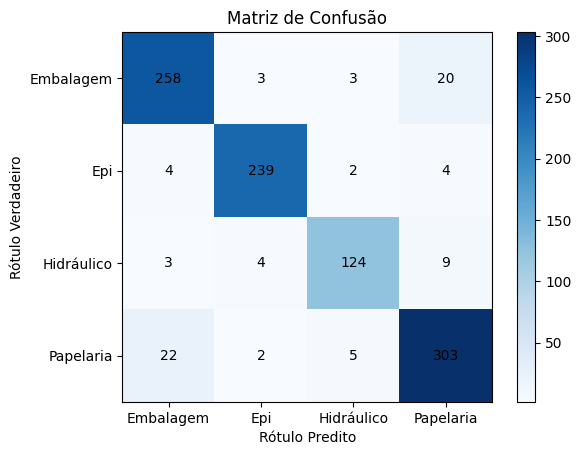

In [11]:
conf_matrix = confusion_matrix(y_test_original,y_pred_original)
labels = np.unique(y_pred_original)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()

In [12]:
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)
indices = np.where(y_pred_original != y_test_original)[0]
previsoes_erradas =  pd.DataFrame({
    'Predita': y_pred_original[indices],
    'Correta': y_test_original[indices],
    'Descrição': df['descricao'][y_test[indices]].values
})

print("Tabela de Previsões Categorias Incorretas:")
#print(previsoes_erradas)
previsoes_erradas_agrupada = previsoes_erradas.groupby(['Predita', 'Correta', 'Descrição']).size().reset_index(name='Quantidade')
previsoes_erradas_agrupada
#previsoes_erradas.to_csv('data/previsoes_erradas.csv', index=False)

Tabela de Previsões Categorias Incorretas:


,Predita,Correta,Descrição,Quantidade
0,Embalagem,Epi,caneta bps pilot,4
1,Embalagem,Hidráulico,caneta marcador permanente acrilex ponta dupla,3
2,Embalagem,Papelaria,caneta retocar madeira branco corcel,22
3,Epi,Embalagem,caneta bic cristal,3
4,Epi,Hidráulico,caneta marcador permanente acrilex ponta dupla,4
5,Epi,Papelaria,caneta retocar madeira branco corcel,2
6,Hidráulico,Embalagem,caneta bic cristal,3
7,Hidráulico,Epi,caneta bps pilot,2
8,Hidráulico,Papelaria,caneta retocar madeira branco corcel,5
9,Papelaria,Embalagem,caneta bic cristal,20


Otimização do optimizer do modelo inicial

In [13]:

densidade = 1  
while True:
    model = tf.keras.Sequential([
        Dense(densidade, activation='relu', input_shape=(X_train_tfidf.shape[1],)),  
        Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)  
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train_tfidf, y_train, epochs=epochs, validation_data=(X_test_tfidf, y_test), verbose=0, callbacks=[early_stopping])
    if early_stopping.stopped_epoch > 0:
        break
    densidade += 1

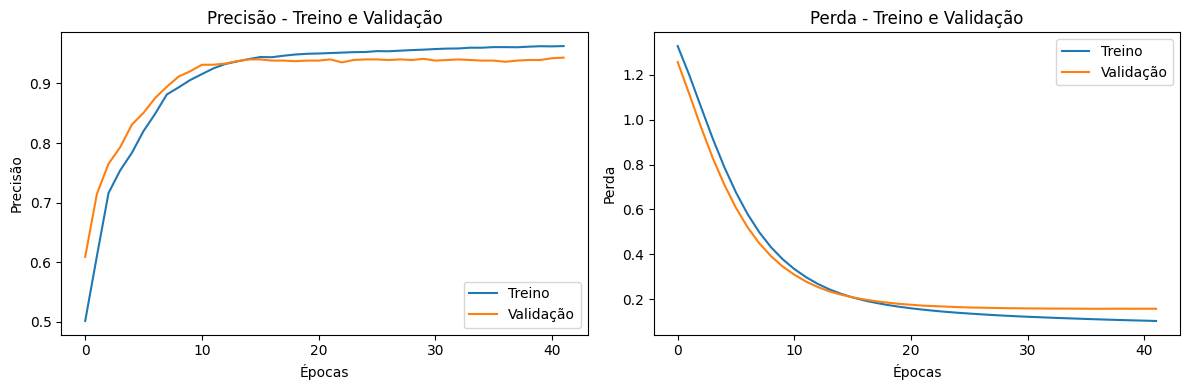

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.title('Precisão - Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda - Treino e Validação')

plt.tight_layout()
plt.show()

In [15]:
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)
print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))

32/32 [==============================] - 0s 491us/step
Classification Report:
              precision    recall  f1-score   support

   Embalagem       0.90      0.92      0.91       284
         Epi       0.98      0.98      0.98       249
  Hidráulico       0.96      0.96      0.96       140
   Papelaria       0.93      0.92      0.92       332

    accuracy                           0.94      1005
   macro avg       0.94      0.94      0.94      1005
weighted avg       0.94      0.94      0.94      1005



In [16]:
print(f"Densidade: {densidade:.4f}")
print(f"Numero de classes: {num_classes:.4f}")
model.summary()

Densidade: 4.0000
Numero de classes: 4.0000
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 4)                 13212     
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
Total params: 13232 (51.69 KB)
Trainable params: 13232 (51.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


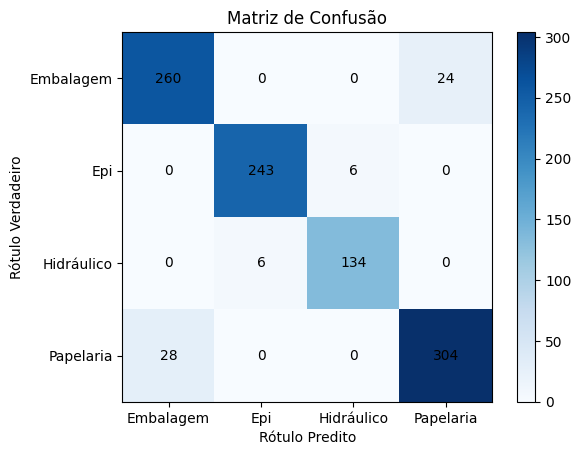

In [17]:
conf_matrix = confusion_matrix(y_test_original,y_pred_original)
labels = np.unique(y_pred_original)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()

In [18]:
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)
indices = np.where(y_pred_original != y_test_original)[0]
previsoes_erradas =  pd.DataFrame({
    'Predita': y_pred_original[indices],
    'Correta': y_test_original[indices],
    'Descrição': df['descricao'][y_test[indices]].values
})

print("Tabela de Previsões Categorias Incorretas:")
#print(previsoes_erradas)
previsoes_erradas_agrupada = previsoes_erradas.groupby(['Predita', 'Correta', 'Descrição']).size().reset_index(name='Quantidade')
previsoes_erradas_agrupada
#previsoes_erradas.to_csv('data/previsoes_erradas.csv', index=False)

Tabela de Previsões Categorias Incorretas:


,Predita,Correta,Descrição,Quantidade
0,Embalagem,Papelaria,caneta retocar madeira branco corcel,28
1,Epi,Hidráulico,caneta marcador permanente acrilex ponta dupla,6
2,Hidráulico,Epi,caneta bps pilot,6
3,Papelaria,Embalagem,caneta bic cristal,24


Modelo Conv1D

In [19]:

# Modelo com Conv1D
densidade = 1 
cov1d_filters = 1 
while True:
    model = tf.keras.Sequential([
        Conv1D(filters=cov1d_filters, kernel_size=3, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)),  
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    X_train_tfidf_reshaped = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
    X_test_tfidf_reshaped = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)
    history = model.fit(X_train_tfidf_reshaped, y_train, epochs=epochs, validation_data=(X_test_tfidf_reshaped, y_test), verbose=0, callbacks=[early_stopping])
    if early_stopping.stopped_epoch > 0:
        break
    cov1d_filters += 1

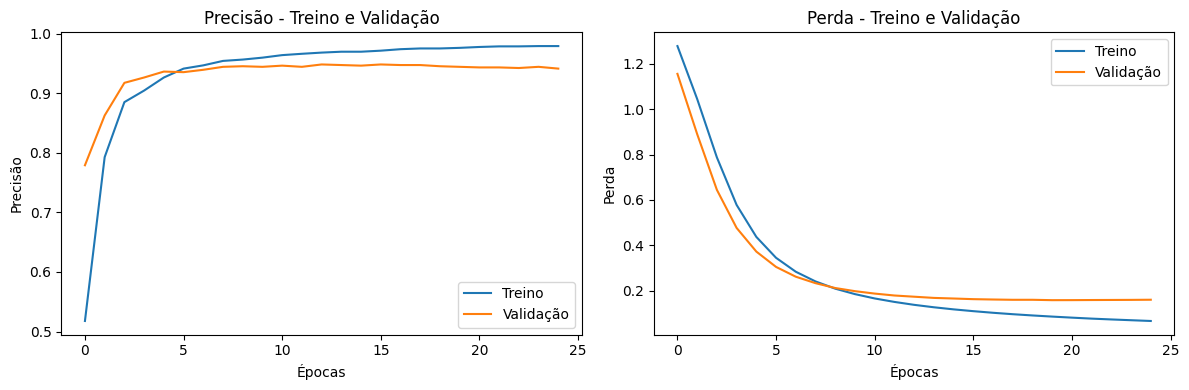

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.title('Precisão - Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda - Treino e Validação')

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 1ms/step


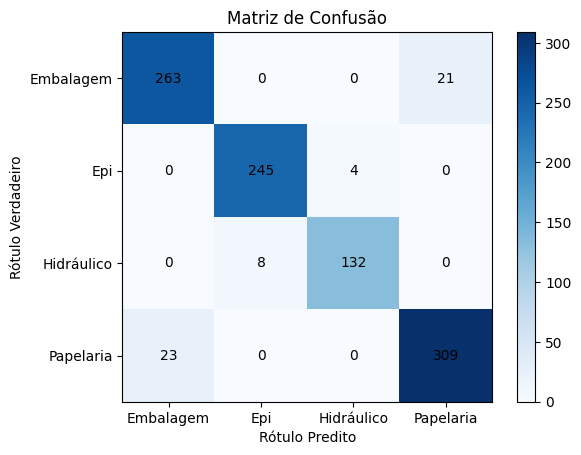

In [21]:
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)
conf_matrix = confusion_matrix(y_test_original,y_pred_original)
labels = np.unique(y_pred_original)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()

In [22]:
print(f"Densidade: {densidade:.4f}")
print(f"Numero de classes: {num_classes:.4f}")
print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))
model.summary()

Densidade: 1.0000
Numero de classes: 4.0000
Classification Report:
              precision    recall  f1-score   support

   Embalagem       0.92      0.93      0.92       284
         Epi       0.97      0.98      0.98       249
  Hidráulico       0.97      0.94      0.96       140
   Papelaria       0.94      0.93      0.93       332

    accuracy                           0.94      1005
   macro avg       0.95      0.95      0.95      1005
weighted avg       0.94      0.94      0.94      1005

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3300, 1)           4         
                                                                 
 flatten (Flatten)           (None, 3300)              0         
                                                                 
 dense_12 (Dense)            (None, 4)                 13204     
              

In [23]:
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)
indices = np.where(y_pred_original != y_test_original)[0]
previsoes_erradas =  pd.DataFrame({
    'Predita': y_pred_original[indices],
    'Correta': y_test_original[indices],
    'Descrição': df['descricao'][y_test[indices]].values
})

print("Tabela de Previsões Categorias Incorretas:")
#print(previsoes_erradas)
previsoes_erradas_agrupada = previsoes_erradas.groupby(['Predita', 'Correta', 'Descrição']).size().reset_index(name='Quantidade')
previsoes_erradas_agrupada

Tabela de Previsões Categorias Incorretas:


,Predita,Correta,Descrição,Quantidade
0,Embalagem,Papelaria,caneta retocar madeira branco corcel,23
1,Epi,Hidráulico,caneta marcador permanente acrilex ponta dupla,8
2,Hidráulico,Epi,caneta bps pilot,4
3,Papelaria,Embalagem,caneta bic cristal,21


Otimização modelo convi1D


In [24]:
#Modelo adicionando Embedding e Conv1D
while increment:
    output_dim = initial_output_dim + 1 
    cov1d_filters = initial_cov1d_filters + 1
    model = tf.keras.Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=output_dim, input_length=max_length),
        Conv1D(filters=cov1d_filters, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(num_classes, activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_test), verbose=0, callbacks=[early_stopping])
   # history = model.fit(X_train_tfidf, y_train, epochs=epochs, validation_data=(X_test_tfidf, y_test), verbose=0, callbacks=[early_stopping])
    #history_df = pd.DataFrame(history.history)
    if early_stopping.stopped_epoch > 0:
        break
    i += 1
   

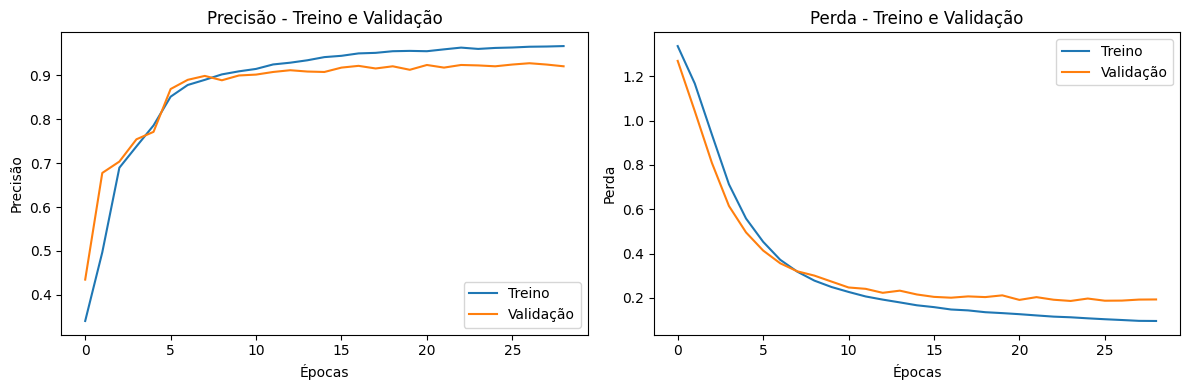

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.title('Precisão - Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda - Treino e Validação')

plt.tight_layout()
plt.show()

In [26]:
#adicionado optmizer
while increment:
    output_dim = initial_output_dim + 1 
    cov1d_filters = initial_cov1d_filters + 1
    model = tf.keras.Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=output_dim, input_length=max_length),
        Conv1D(filters=cov1d_filters, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(num_classes, activation='softmax')  
    ])
    optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)  
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
   # history = model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_test), verbose=0, callbacks=[early_stopping])   
    history = model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_test_padded, y_test), verbose=0, callbacks=[early_stopping])
    history_df = pd.DataFrame(history.history)
    if early_stopping.stopped_epoch > 0:
        break
    i += 1
   
    

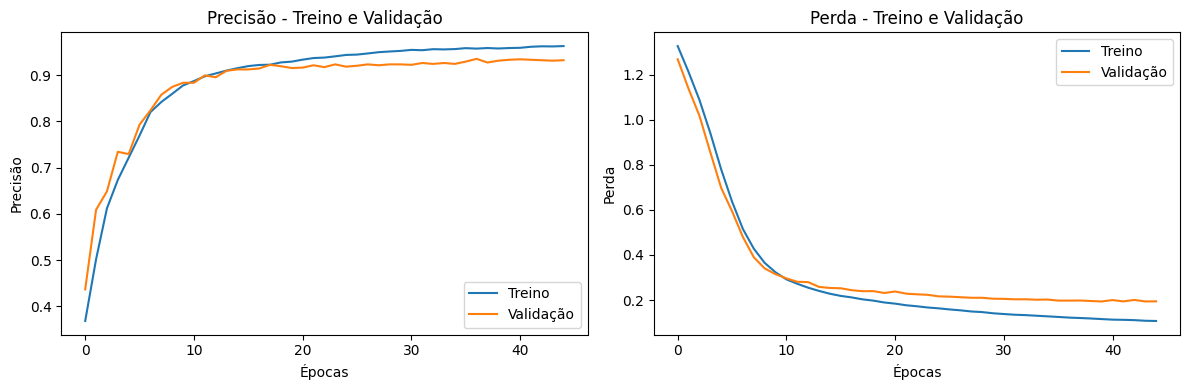

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.title('Precisão - Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Perda - Treino e Validação')

plt.tight_layout()
plt.show()

In [28]:
# Avaliar o modelo e obter as previsões
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

32/32 [==============================] - 0s 587us/step


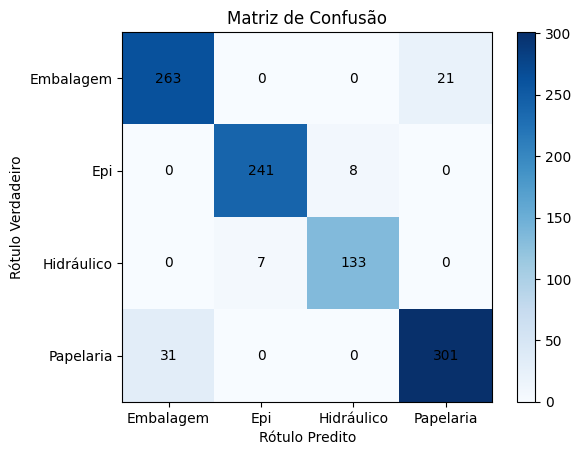

In [29]:
#conf_matrix = confusion_matrix(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test_original,y_pred_original)
labels = np.unique(y_pred_original)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()

In [30]:
print(f"Output dim: {output_dim:.4f}")
print(f"cov1d_filters: {cov1d_filters:.4f}")


Output dim: 2.0000
cov1d_filters: 3.0000


In [31]:
print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))

Classification Report:
              precision    recall  f1-score   support

   Embalagem       0.89      0.93      0.91       284
         Epi       0.97      0.97      0.97       249
  Hidráulico       0.94      0.95      0.95       140
   Papelaria       0.93      0.91      0.92       332

    accuracy                           0.93      1005
   macro avg       0.94      0.94      0.94      1005
weighted avg       0.93      0.93      0.93      1005



In [32]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 646, 2)            6606      
                                                                 
 conv1d_2 (Conv1D)           (None, 646, 3)            9         
                                                                 
 flatten_2 (Flatten)         (None, 1938)              0         
                                                                 
 dense_14 (Dense)            (None, 4)                 7756      
                                                                 
Total params: 14371 (56.14 KB)
Trainable params: 14371 (56.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [34]:
##history_df = pd.DataFrame(history.history)
indices = np.where(y_pred_original != y_test_original)[0]
previsoes_erradas =  pd.DataFrame({
    'Predita': y_pred_original[indices],
    'Correta': y_test_original[indices],
    'Descrição': df['descricao'][y_test[indices]].values
})

print("Tabela de Previsões Categorias Incorretas:")
print(previsoes_erradas)
previsoes_erradas.to_csv('data/previsoes_erradas.csv', index=False)



Tabela de Previsões Categorias Incorretas:
       Predita    Correta                             Descrição
0    Papelaria  Embalagem                    caneta bic cristal
1    Embalagem  Papelaria  caneta retocar madeira branco corcel
2    Papelaria  Embalagem                    caneta bic cristal
3    Embalagem  Papelaria  caneta retocar madeira branco corcel
4    Papelaria  Embalagem                    caneta bic cristal
..         ...        ...                                   ...
62  Hidráulico        Epi                      caneta bps pilot
63   Embalagem  Papelaria  caneta retocar madeira branco corcel
64   Embalagem  Papelaria  caneta retocar madeira branco corcel
65  Hidráulico        Epi                      caneta bps pilot
66   Embalagem  Papelaria  caneta retocar madeira branco corcel

[67 rows x 3 columns]


In [35]:
previsoes_erradas_agrupada = previsoes_erradas.groupby(['Predita', 'Correta', 'Descrição']).size().reset_index(name='Quantidade')
previsoes_erradas_agrupada

,Predita,Correta,Descrição,Quantidade
0,Embalagem,Papelaria,caneta retocar madeira branco corcel,31
1,Epi,Hidráulico,caneta marcador permanente acrilex ponta dupla,7
2,Hidráulico,Epi,caneta bps pilot,8
3,Papelaria,Embalagem,caneta bic cristal,21
